In [1]:
!nvidia-smi

Tue Nov  8 21:17:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from torchvision.datasets import MNIST
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
data_dir = Path('/app/data/mnist')
data_dir.mkdir(exist_ok=True, parents=True)

In [4]:
dataset = MNIST(root=data_dir, train=True, download=True)

In [5]:
pil_img, idx = dataset[0]
np_img = np.array(pil_img)

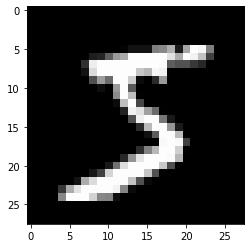

In [6]:
plt.imshow(np_img, cmap='gray')

# Lets add some noise

In [23]:
t_img = torch.tensor(np_img) / 255.

In [36]:
noise = torch.empty(28, 28).normal_(mean=0., std=0.15)

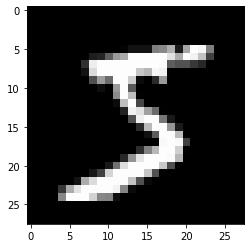

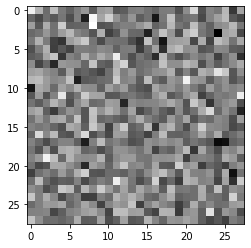

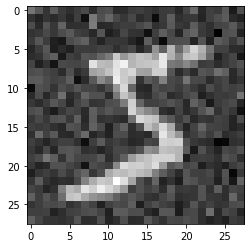

In [37]:
plt.imshow(t_img, cmap='gray')
plt.show()
plt.imshow(noise, cmap='gray')
plt.show()
plt.imshow(t_img+noise, cmap='gray')

# Noise variance scheduling

In [43]:
T = torch.linspace(0, 0.999, 1000)
torch.pi = torch.acos(torch.zeros(1)).item() * 2

In [44]:
torch.pi

3.1415927410125732

In [45]:
s = 0.008

def var_scale(t):
    return torch.cos((t+s)/(1+s)*(torch.pi/2))**2

In [46]:
T_scale = var_scale(T)

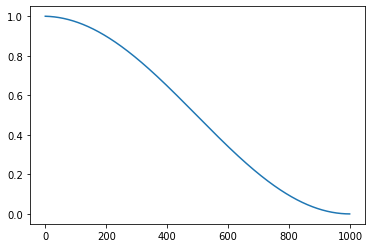

In [48]:
plt.plot(T_scale)

# Apply scaled noise

In [49]:
def q(x_t, b_t):
    noise = torch.empty(x_t.shape).normal_(mean=torch.sqrt(1.-b_t), std=b_t)
    return x_t + noise

In [61]:
noised = q(t_img, T_scale[0])

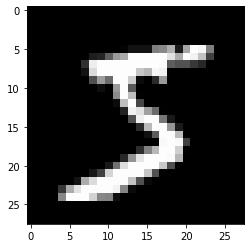

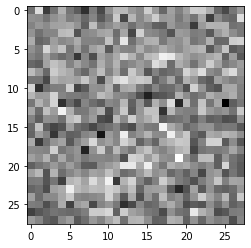

In [62]:
plt.imshow(t_img, cmap='gray')
plt.show()
plt.imshow(noised, cmap='gray')

# U-Net definition

In [99]:
from vanilla_vae import VanillaVAE

In [146]:
# p = VanillaVAE(in_channels=3, latent_dim=10)
p = VanillaVAE(in_channels=1, latent_dim=10)

In [147]:
noised.unsqueeze(0).unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [148]:
res = p(torch.rand(2, 1, 64, 64))

In [149]:
res[0].shape

torch.Size([2, 3, 64, 64])